In [1]:



!pip install -q transformers
# numpy
!pip install -q numpy
# Pillow (แทน PIL)
!pip install  pillow
# datasets (Hugging Face)
!pip install datasets
# transformers + accelerate (สำหรับ Segformer)
!pip install transformers accelerate
# evaluate (สำหรับ metric เช่น mIoU)
!pip install evaluate
# PyTorch (โหลดยางล้อให้เครื่องบิน)
# ถ้าใช้ Colab GPU ปกติ ลองลิงก์ cu121 ก่อน
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install torch torchvision torchaudio
!pip install -U "transformers>=4.44" "datasets" "evaluate" "accelerate" -q
!pip install -U "transformers>=4.44" "datasets>=2.18" "evaluate>=0.4" "accelerate>=0.33" -q
!pip install matplotlib
!pip install -U hf_transfer -q




Looking in indexes: https://download.pytorch.org/whl/cu121


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
!pip install PyDrive


In [3]:
!pip install --upgrade gdown

import gdown
import os
import zipfile

# File ID จากลิงก์ใหม่
file_id = "1DY7N8hbjjVkd4v_6a387yysjL4WGcZtZ"
zip_path = "./gpr_dataset.zip"

# ดาวน์โหลดไฟล์ zip จาก Google Drive
gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_path, quiet=False)

# แตกไฟล์ zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("./gpr_dataset")

print("✅ Download and unzip completed! Files are in ./gpr_dataset")

Downloading...
From (original): https://drive.google.com/uc?id=1DY7N8hbjjVkd4v_6a387yysjL4WGcZtZ
From (redirected): https://drive.google.com/uc?id=1DY7N8hbjjVkd4v_6a387yysjL4WGcZtZ&confirm=t&uuid=2839f0fd-a384-4a39-88e3-df559e0bbc34
To: /workspace/gpr_dataset.zip
100%|██████████| 193M/193M [00:05<00:00, 37.3MB/s] 


✅ Download and unzip completed! Files are in ./gpr_dataset


In [4]:
import transformers, datasets, evaluate, accelerate
import os

print("transformers:", transformers.__version__)
print("datasets:", datasets.__version__)
print("evaluate:", evaluate.__version__)
print("accelerate:", accelerate.__version__)

transformers: 4.57.1
datasets: 4.3.0
evaluate: 0.4.6
accelerate: 1.11.0


In [5]:
# ====== Cell 1: CONFIG & PATHS ======
import os
from pathlib import Path

# ---- แก้พาธให้ตรงโครงสร้างของคุณ ----
ROOT = Path("/workspace/gpr_dataset/data")  # <-- เปลี่ยนตรงนี้ให้ตรงตำแหน่งจริงของคุณ

TRAIN_IMG_DIR = ROOT / "train/images"
TRAIN_MSK_DIR = ROOT / "train/masks"

VAL_IMG_DIR   = ROOT / "val/images"
VAL_MSK_DIR   = ROOT / "val/masks"

TEST_IMG_DIR  = ROOT / "test"   # ผู้ใช้พิมพ์ว่า test/image -> ผมถือว่าเป็น "images"   # ต้องมี ถ้าจะคำนวณ mIoU ของ test

# ---- Task config ----
NUM_CLASSES   = 2              # แก้จำนวนคลาสตามงานคุณ
IGNORE_INDEX  = 255            # ถ้ามี label=255 เป็น void/ignore
IMAGE_SIZE    = 512            # ขนาดรีไซส์สำหรับโมเดล (SegFormer fine-tuned ส่วนใหญ่ 512)

MODEL_NAME    = "nvidia/segformer-b0-finetuned-ade-512-512"
OUTPUT_DIR    = "./outputs_segformer_road"  # โฟลเดอร์เซฟ checkpoint

SEED          = 42
EPOCHS        = 25
LR            = 5e-5
BATCH_SIZE    = 10

# ตรวจพาธเบื้องต้น
for p in [TRAIN_IMG_DIR, TRAIN_MSK_DIR, VAL_IMG_DIR, VAL_MSK_DIR, TEST_IMG_DIR]:
    if not Path(p).exists():
        print(f"[WARN] Path not found: {p}")


In [6]:
# ====== Cell 2: IMPORTS & DATASET UTILS ======
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation

# ให้แน่ใจว่าใช้ processors แทน tokenizer เพื่อเลี่ยง FutureWarning
processor = AutoImageProcessor.from_pretrained(
    MODEL_NAME,
    do_reduce_labels=False,   # segmentation ไม่ลด label index
)

# id2label/label2id พื้นฐาน (แก้ชื่อคลาสจริงได้)
id2label = {i: f"class_{i}" for i in range(NUM_CLASSES)}
label2id = {v: k for k, v in id2label.items()}

class RoadSegDataset(Dataset):
    """
    Dataset แบบอ่านจากโฟลเดอร์ (images, masks).
    - mask ควรเป็นแผนที่ label ที่ค่าภายในอยู่ใน [0..NUM_CLASSES-1] หรือมี 255 สำหรับ ignore
    - ถ้าเจอค่ามาสก์ 255 และ NUM_CLASSES==2 จะ map เป็น ignore (ไม่แปลง 255->1 โดยอัตโนมัติ เว้นจัดการใน compute_metrics)
    """
    def __init__(self, img_dir, msk_dir, processor, image_size=512, has_mask=True):
        self.img_dir = Path(img_dir)
        self.msk_dir = Path(msk_dir) if has_mask else None
        self.processor = processor
        self.image_size = image_size
        self.has_mask = has_mask

        # สร้างลิสต์ไฟล์ที่ match กันด้วยชื่อ
        img_files = sorted([p for p in self.img_dir.glob("*") if p.suffix.lower() in [".png",".jpg",".jpeg",".tif",".tiff"]])
        if has_mask:
            mask_files = sorted([p for p in self.msk_dir.glob("*") if p.suffix.lower() in [".png",".jpg",".jpeg",".tif",".tiff"]])
            img_stems  = {p.stem for p in img_files}
            mask_stems = {p.stem for p in mask_files}
            keep = sorted(list(img_stems & mask_stems))
            self.img_paths  = [self.img_dir / (k + (next(s for s in [".png",".jpg",".jpeg",".tif",".tiff"] if (self.img_dir/(k+s)).exists()))) for k in keep]
            self.mask_paths = [self.msk_dir / (k + (next(s for s in [".png",".jpg",".jpeg",".tif",".tiff"] if (self.msk_dir/(k+s)).exists()))) for k in keep]
        else:
            self.img_paths  = img_files
            self.mask_paths = None

        if len(self.img_paths) == 0:
            print(f"[WARN] No images found in {self.img_dir}")
        if has_mask and len(self.mask_paths) == 0:
            print(f"[WARN] No masks found in {self.msk_dir}")

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert("RGB")

        if self.has_mask:
            msk = Image.open(self.mask_paths[idx])
            # ถ้า mask เป็น RGB ให้แปลงเป็น L ก่อน
            if msk.mode != "L":
                msk = msk.convert("L")
            msk = np.array(msk).astype(np.int64)
        else:
            msk = None

        # ใช้ processor ทำรีไซส์/normalize พร้อมสร้าง labels
        if self.has_mask:
            encoded = self.processor(
                images=img,
                segmentation_maps=msk,
                size={"height": IMAGE_SIZE, "width": IMAGE_SIZE},
                return_tensors="pt"
            )
            # squeeze batch dim
            for k in encoded:
                encoded[k] = encoded[k].squeeze(0)
            return encoded
        else:
            encoded = self.processor(
                images=img,
                size={"height": IMAGE_SIZE, "width": IMAGE_SIZE},
                return_tensors="pt"
            )
            for k in encoded:
                encoded[k] = encoded[k].squeeze(0)
            return encoded


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'reduce_labels'
  image_processor = cls(**image_processor_dict)


In [7]:
# ====== Cell 3: BUILD DATASETS & MODEL (no test masks) ======
train_ds = RoadSegDataset(TRAIN_IMG_DIR, TRAIN_MSK_DIR, processor, image_size=IMAGE_SIZE, has_mask=True)
val_ds   = RoadSegDataset(VAL_IMG_DIR,   VAL_MSK_DIR,   processor, image_size=IMAGE_SIZE, has_mask=True)

# --- TEST: images only (no masks) ---
test_ds  = RoadSegDataset(TEST_IMG_DIR, None, processor, image_size=IMAGE_SIZE, has_mask=False)

model = SegformerForSemanticSegmentation.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_CLASSES,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test (images only): {len(test_ds)} | device: {device}")


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train: 630 | Val: 168 | Test (images only): 168 | device: cuda


In [8]:
# ====== Cell 4: METRICS (mIoU) ======
import evaluate
import torch.nn.functional as F

metric_mIoU = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
    """
    - รองรับทั้ง EvalPrediction และ tuple
    - resize logits -> size ของ labels ก่อน argmax
    - จัดการ ignore_index=255
    - NOTE: ถ้า label test เป็น {0,255} สำหรับ binary ให้ตั้ง IGNORE_INDEX=255 เพื่อไม่นับ 255
    """
    logits, labels = (eval_pred if isinstance(eval_pred, tuple)
                      else (eval_pred.predictions, eval_pred.label_ids))

    # to torch tensors
    if isinstance(logits, np.ndarray):
        logits = torch.from_numpy(logits)
    if isinstance(labels, np.ndarray):
        labels_t = torch.from_numpy(labels)
    else:
        labels_t = labels

    H, W = labels_t.shape[-2], labels_t.shape[-1]
    logits = logits.float()
    if logits.shape[-2:] != (H, W):
        logits = F.interpolate(logits, size=(H, W), mode="bilinear", align_corners=False)

    preds = logits.argmax(1).cpu().numpy().astype(np.int64)
    refs  = labels_t.cpu().numpy().astype(np.int64)

    # ถ้าเป็น binary และพบ label 255 ใน GT -> ใช้ ignore_index=255
    ig = IGNORE_INDEX if IGNORE_INDEX is not None else None

    out = metric_mIoU.compute(
        predictions=preds,
        references=refs,
        num_labels=NUM_CLASSES,
        ignore_index=ig,
        reduce_labels=False
    )
    # ชื่อ key มาตรฐาน -> Trainer จะ log เป็น eval_mean_iou/train_mean_iou/test_mean_iou ตาม prefix
    return {"mean_iou": float(out["mean_iou"])}


In [9]:
# ====== Cell 5: TRAINING ARGS & CALLBACK ======
from transformers import TrainingArguments, Trainer
from transformers.trainer_utils import IntervalStrategy
from transformers import TrainerCallback
import numpy as np

args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LR,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,

    # เวอร์ชันของคุณรองรับ 'eval_strategy'
    eval_strategy=IntervalStrategy.EPOCH,     # evaluate ทุก epoch

    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    save_total_limit=2,

    report_to=[],                 # ไม่ส่ง logger ภายนอก
    push_to_hub=False,
    remove_unused_columns=False,

    # ปิด multiprocessing ของ DataLoader กัน error ในโน้ตบุ๊ก/py3.12
    dataloader_num_workers=0,
    dataloader_persistent_workers=False,
    dataloader_pin_memory=False,

    fp16=torch.cuda.is_available(),
    seed=SEED,

    load_best_model_at_end=True,
    metric_for_best_model="eval_mean_iou",
    greater_is_better=True,
)

# Callback: log train metrics (train_mean_iou, train_loss) ทุกจบ epoch
class LogTrainMetricsEachEpoch(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        m_train = trainer.evaluate(eval_dataset=trainer.train_dataset, metric_key_prefix="train")
        payload = {"epoch": float(state.epoch) if state.epoch is not None else np.nan}
        payload.update(m_train)
        trainer.log(payload)


In [10]:
# ====== Cell 6: TRAIN ======
from transformers import default_data_collator
data_collator = default_data_collator

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,             # ใช้ "val" เป็น eval ระหว่างเทรน
    processing_class=processor,      # แทน tokenizer= เพื่อเลี่ยง FutureWarning
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# เก็บ train_mean_iou ทุก epoch
trainer.add_callback(LogTrainMetricsEachEpoch())

train_result = trainer.train()
trainer.save_model(OUTPUT_DIR)
processor.save_pretrained(OUTPUT_DIR)

print("[OK] Training finished & saved to", OUTPUT_DIR)


Epoch,Training Loss,Validation Loss,Mean Iou
1,0.574100,0.428054,0.609158
2,0.405500,0.307169,0.635068
3,0.319400,0.263471,0.666604
4,0.264600,0.247772,0.693231
5,0.245700,0.232711,0.695933
6,0.237600,0.226543,0.708340
7,0.232000,0.222069,0.713113
8,0.223900,0.216267,0.703183
9,0.217800,0.212742,0.712039
10,0.223400,0.214751,0.723085


/usr/local/lib/python3.12/dist-packages/datasets/features/image.py:371: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/usr/local/lib/python3.12/dist-packages/datasets/features/image.py:371: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/usr/local/lib/python3.12/dist-packages/datasets/features/image.py:371: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/usr/local/lib/python3.12/dist-packages/datasets/features/image.py:371: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible 

[OK] Training finished & saved to ./outputs_segformer_road


In [11]:
# ====== Cell 7: FINAL EVALUATION (TEST) ======
test_metrics = {}
if hasattr(test_ds, "__len__") and len(test_ds) > 0:
    # ต้องมี test masks ถึงจะคำนวณ mIoU ได้
    test_metrics = trainer.evaluate(eval_dataset=test_ds, metric_key_prefix="test")
    print({k: v for k, v in test_metrics.items() if ("loss" in k) or ("iou" in k.lower())})
else:
    print("[WARN] test_ds ว่างเปล่าหรือไม่มี masks -> จะไม่มี test_mean_iou")


{}


,loss,eval_loss,train_mean_iou
epoch,,,
0.793651,0.5741,NaN,NaN
1.000000,NaN,NaN,0.609158
1.587302,0.4055,NaN,NaN
2.000000,NaN,NaN,0.635068
2.380952,0.3194,NaN,NaN
3.000000,NaN,NaN,0.666604
3.174603,0.2767,NaN,NaN
3.968254,0.2646,NaN,NaN
4.000000,NaN,NaN,0.693231


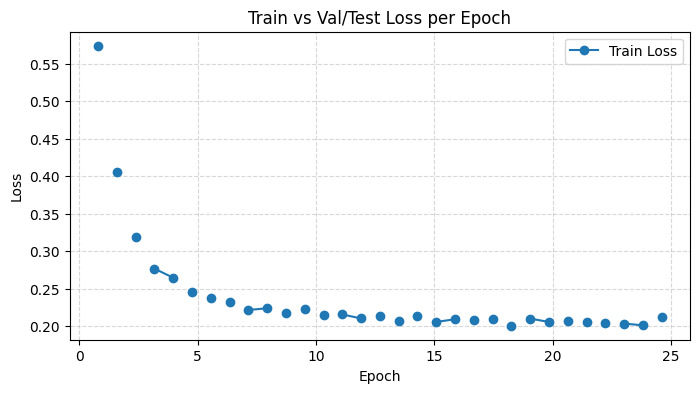

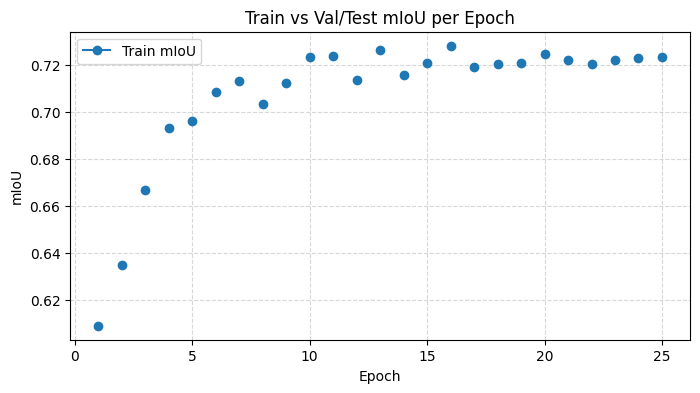

In [12]:
# ====== Cell 8: LOG TABLE & PLOTS ======
import pandas as pd
import matplotlib.pyplot as plt

logs = getattr(trainer.state, "log_history", [])
df = pd.DataFrame(logs)

# กันคอลัมน์หาย
for col in ["epoch", "loss", "eval_loss"]:
    if col not in df.columns:
        df[col] = np.nan

# auto-detect ชื่อคอลัมน์ IoU (รองรับหลายชื่อ)
def pick_first(cols, cond):
    for c in cols:
        if cond(c): return c
    return None

col_eval_iou  = pick_first(df.columns, lambda c: c.startswith("eval_")  and "iou" in c.lower())
col_train_iou = pick_first(df.columns, lambda c: c.startswith("train_") and "iou" in c.lower())

# รวมค่าต่อ epoch
keep_cols = ["loss","eval_loss"]
if col_eval_iou:  keep_cols.append(col_eval_iou)
if col_train_iou: keep_cols.append(col_train_iou)

per_epoch = (
    df.dropna(subset=["epoch"])
      .groupby("epoch", as_index=True)[keep_cols]
      .last()
      .sort_index()
)

display(per_epoch.head(20))

# ----- Plot 1: Loss (train vs val + test dashed) -----
plt.figure(figsize=(8,4))
if "loss" in per_epoch and not per_epoch["loss"].isna().all():
    plt.plot(per_epoch.index, per_epoch["loss"], marker="o", label="Train Loss")

if "eval_loss" in per_epoch and not per_epoch["eval_loss"].isna().all():
    plt.plot(per_epoch.index, per_epoch["eval_loss"], marker="o", label="Val Loss")

t_loss = test_metrics.get("test_loss")
if t_loss is not None and len(per_epoch.index) > 0:
    plt.hlines(t_loss, xmin=per_epoch.index.min(), xmax=per_epoch.index.max(),
               linestyles="dashed", label=f"Test Loss = {t_loss:.4f}")

plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Train vs Val/Test Loss per Epoch")
plt.grid(True, linestyle="--", alpha=0.5); plt.legend(); plt.show()

# ----- Plot 2: mIoU (train vs val + test dashed) -----
plt.figure(figsize=(8,4))
if col_train_iou:
    plt.plot(per_epoch.index, per_epoch[col_train_iou], marker="o", label="Train mIoU")

if col_eval_iou:
    plt.plot(per_epoch.index, per_epoch[col_eval_iou], marker="o", label="Val mIoU")

t_miou = next((test_metrics.get(k) for k in [
    "test_mean_iou","test_mIoU","test_miou","test_iou"
] if k in test_metrics), None)
if t_miou is not None and len(per_epoch.index) > 0:
    plt.hlines(t_miou, xmin=per_epoch.index.min(), xmax=per_epoch.index.max(),
               linestyles="dashed", label=f"Test mIoU = {t_miou:.4f}")

plt.xlabel("Epoch"); plt.ylabel("mIoU"); plt.title("Train vs Val/Test mIoU per Epoch")
plt.grid(True, linestyle="--", alpha=0.5); plt.legend(); plt.show()


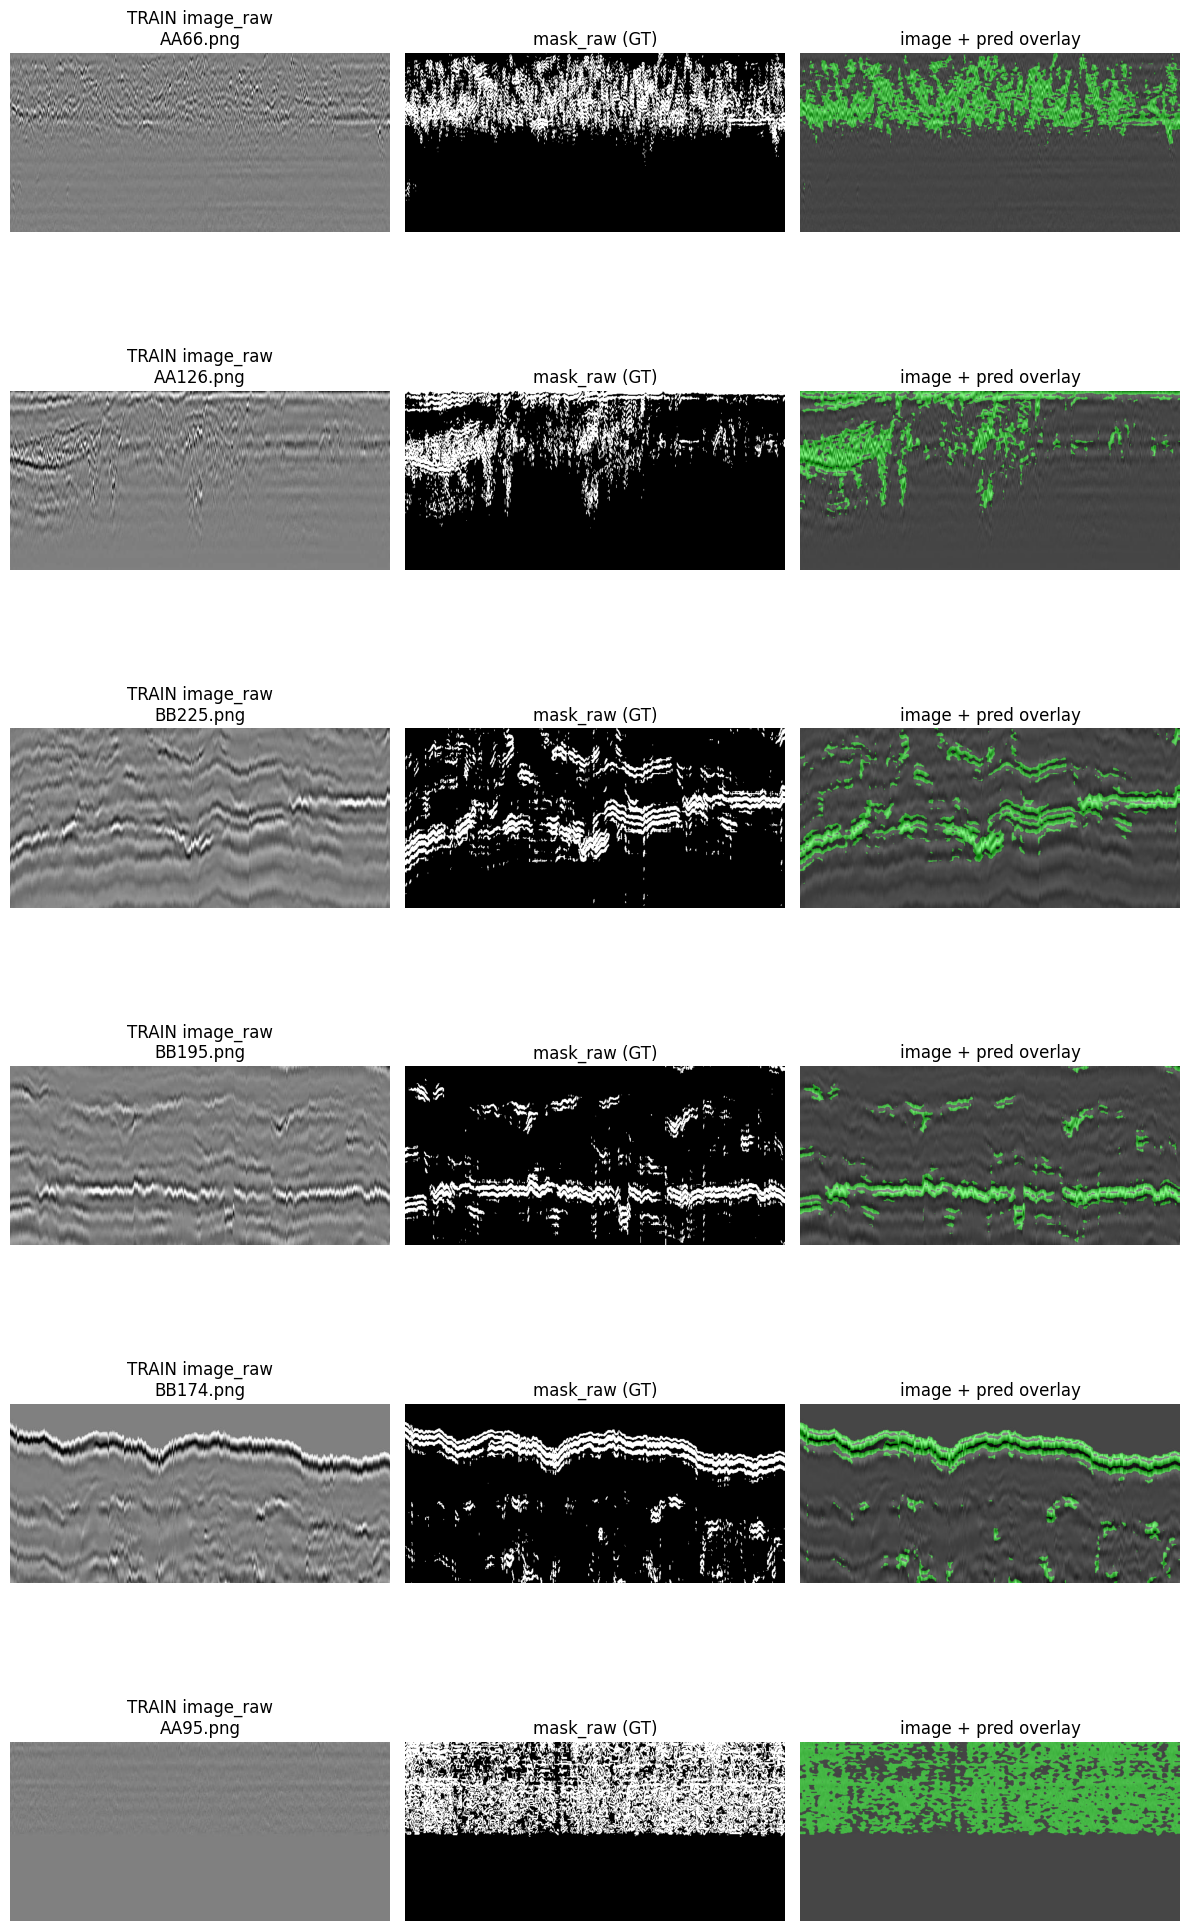

In [13]:
# ===== Visualize TRAIN samples: image_raw | mask_raw | image + pred overlay =====
import os, random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

def _to_uint8(img_np):
    """ensure uint8 0..255"""
    if img_np.dtype != np.uint8:
        img_np = np.clip(img_np, 0, 255).astype(np.uint8)
    return img_np

def overlay_mask_on_image(img_rgb, mask_ids, alpha=0.45, color=(0, 255, 0)):
    """
    img_rgb: HxWx3 uint8
    mask_ids: HxW int (binary/ multiclass). สำหรับ binary จะทับเฉพาะ mask==1
    """
    img = img_rgb.astype(np.float32)
    h, w = mask_ids.shape
    ov = np.zeros((h, w, 3), dtype=np.float32)

    if NUM_CLASSES == 2:
        m = (mask_ids == 1)
        ov[m] = np.array(color, dtype=np.float32)
    else:
        # ถ้า multi-class: ไล่สีง่ายๆ ตาม index
        rng = np.random.default_rng(123)
        lut = rng.integers(0, 255, size=(NUM_CLASSES, 3), dtype=np.uint8)
        lut[0] = np.array([0, 0, 0], dtype=np.uint8)  # พื้นหลังไม่ทับ
        ov = lut[mask_ids].astype(np.float32)

    mixed = img*(1-alpha) + ov*alpha
    return mixed.clip(0,255).astype(np.uint8)

def predict_mask_for_image(pil_img):
    """
    รันโมเดลบนภาพเดี่ยว (ไม่ใช้ mask GT) แล้วคืน mask_pred ที่ขนาดเท่า original
    """
    model.eval()
    with torch.no_grad():
        enc = processor(images=pil_img, size={"height": IMAGE_SIZE, "width": IMAGE_SIZE}, return_tensors="pt")
        pixel_values = enc["pixel_values"].to(device)
        logits = model(pixel_values=pixel_values).logits  # (1,C,h',w')
        # resize logits -> original size
        h0, w0 = pil_img.height, pil_img.width
        logits_up = F.interpolate(logits, size=(h0, w0), mode="bilinear", align_corners=False)
        pred = logits_up.argmax(1)[0].detach().cpu().numpy().astype(np.int64)
    return pred

def load_mask_gt(path):
    m = Image.open(path)
    if m.mode != "L":
        m = m.convert("L")
    m = np.array(m)
    # ถ้า binary และ GT เป็น {0,255} -> map เป็น 0/1 เพื่อโชว์สวย ๆ
    if NUM_CLASSES == 2 and m.max() == 255:
        m = (m == 255).astype(np.uint8)
    return m

def list_images(img_dir):
    exts = (".png",".jpg",".jpeg",".tif",".tiff")
    return sorted([p for p in os.listdir(img_dir) if p.lower().endswith(exts)])

# --------- visualize ----------
N_SHOW = 6  # จำนวนตัวอย่างที่อยากโชว์
img_names = list_images(TRAIN_IMG_DIR)
if not img_names:
    raise RuntimeError(f"No images found in {TRAIN_IMG_DIR}")
random.seed(42)
sel = random.sample(img_names, min(N_SHOW, len(img_names)))

ncols = 3
nrows = len(sel)
plt.figure(figsize=(ncols*4, nrows*3.5))

for r, name in enumerate(sel):
    img_path = os.path.join(TRAIN_IMG_DIR, name)
    base = os.path.splitext(name)[0]

    # หา mask ที่ชื่อเดียวกัน
    # ลองด้วยนามสกุลที่พบบ่อย
    mask_path = None
    for ext in [".png",".jpg",".jpeg",".tif",".tiff"]:
        p = os.path.join(TRAIN_MSK_DIR, base + ext)
        if os.path.exists(p):
            mask_path = p
            break

    img = Image.open(img_path).convert("RGB")
    img_np = _to_uint8(np.array(img))

    # predict
    pred_ids = predict_mask_for_image(img)
    overlay_pred = overlay_mask_on_image(img_np, pred_ids)

    # GT (ถ้ามี)
    if mask_path is not None:
        gt_ids = load_mask_gt(mask_path)
    else:
        gt_ids = np.zeros(pred_ids.shape, dtype=np.uint8)

    # ---- plot 3 columns ----
    ax = plt.subplot(nrows, ncols, r*ncols + 1)
    ax.imshow(img_np)
    ax.set_title(f"TRAIN image_raw\n{name}")
    ax.axis("off")

    ax = plt.subplot(nrows, ncols, r*ncols + 2)
    ax.imshow(gt_ids, cmap="gray")
    ax.set_title("mask_raw (GT)")
    ax.axis("off")

    ax = plt.subplot(nrows, ncols, r*ncols + 3)
    ax.imshow(overlay_pred)
    ax.set_title("image + pred overlay")
    ax.axis("off")

plt.tight_layout()
plt.show()


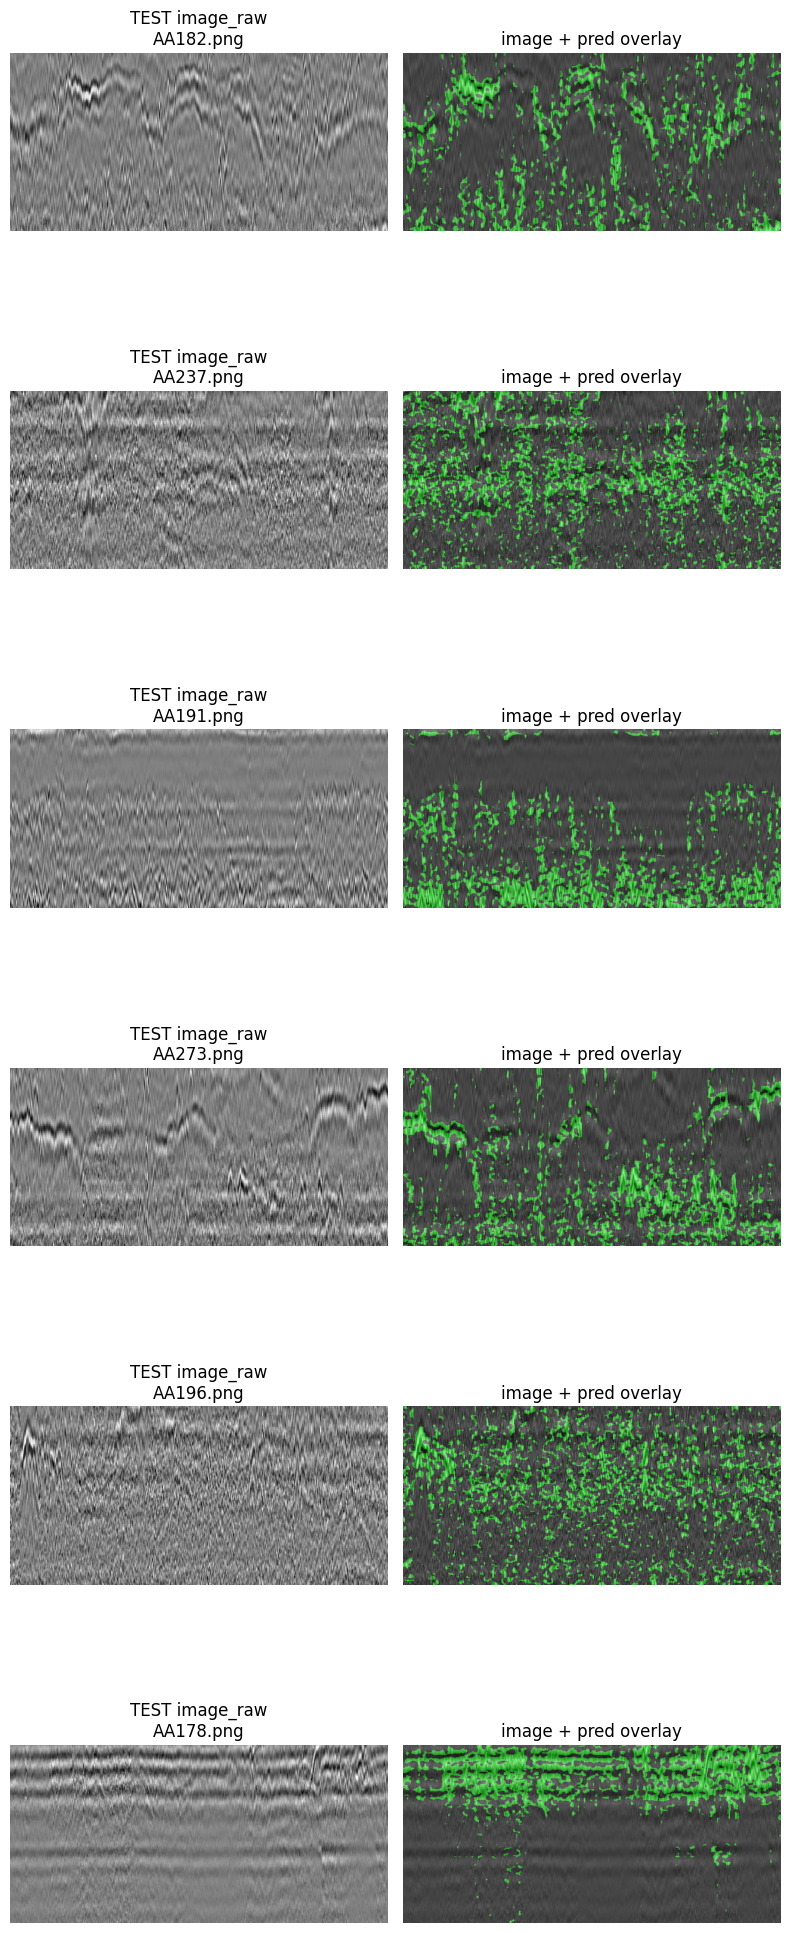

In [14]:
# ===== Visualize TEST samples: image_raw | image + pred overlay =====
import os, random
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

# helper: _to_uint8, overlay_mask_on_image, predict_mask_for_image, list_images (เหมือนเดิม)

N_SHOW = 6
img_names = list_images(TEST_IMG_DIR)
if not img_names:
    raise RuntimeError(f"No images found in {TEST_IMG_DIR}")

random.seed(123)
sel = random.sample(img_names, min(N_SHOW, len(img_names)))

ncols = 2
nrows = len(sel)
plt.figure(figsize=(ncols*4, nrows*3.5))

for r, name in enumerate(sel):
    img_path = os.path.join(TEST_IMG_DIR, name)
    img = Image.open(img_path).convert("RGB")
    img_np = _to_uint8(np.array(img))

    # ทำนาย segmentation mask
    pred_ids = predict_mask_for_image(img)
    overlay_pred = overlay_mask_on_image(img_np, pred_ids)

    # column 1: image_raw
    ax = plt.subplot(nrows, ncols, r*ncols + 1)
    ax.imshow(img_np)
    ax.set_title(f"TEST image_raw\n{name}")
    ax.axis("off")

    # column 2: overlay prediction
    ax = plt.subplot(nrows, ncols, r*ncols + 2)
    ax.imshow(overlay_pred)
    ax.set_title("image + pred overlay")
    ax.axis("off")

plt.tight_layout()
plt.show()



In [15]:
import pandas as pd

# ===== Evaluate ทั้ง train และ test =====
train_metrics = trainer.evaluate(train_ds, metric_key_prefix="train")
test_metrics = trainer.evaluate(test_ds,  metric_key_prefix="test") if len(test_ds) > 0 else {}

# ===== Helper function =====
def extract_metrics(metrics_dict):
    wanted = ["accuracy", "precision", "recall", "f1", "miou", "iou"]
    out = {}
    for k, v in metrics_dict.items():
        if any(w in k.lower() for w in wanted):
            out[k] = v
    return out

train_vals = extract_metrics(train_metrics)
test_vals  = extract_metrics(test_metrics)

# ===== รวมผลเป็นตารางแนวตั้ง =====
all_keys = sorted(set(train_vals.keys()) | set(test_vals.keys()))
rows = []
for k in all_keys:
    rows.append({
        "Metric": k,
        "Train": train_vals.get(k, None),
        "Test": test_vals.get(k, None),
    })

if rows:
    df_metrics = pd.DataFrame(rows).set_index("Metric")
    display(df_metrics.round(4))
else:
    print("[WARN] ไม่พบ metric ที่ตรง (ลองเช็ค compute_metrics() ว่าคืนค่าอะไรบ้าง)")
    print("train metrics:", list(train_metrics.keys()))
    print("test metrics:", list(test_metrics.keys()))


/usr/local/lib/python3.12/dist-packages/datasets/features/image.py:371: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


,Train,Test
Metric,,
train_mean_iou,0.7231,None


In [16]:
# ===== Save model & processor =====
from transformers import pipeline, AutoModelForSemanticSegmentation, AutoImageProcessor

SAVE_PATH = "./segformer_trained_export"

model.save_pretrained(SAVE_PATH)
processor.save_pretrained(SAVE_PATH)

print(f"✅ Model & processor saved to {SAVE_PATH}")


✅ Model & processor saved to ./segformer_trained_export
